In [1]:
! wget http://gaponov.me/hackaton/aggregates.csv
! wget http://gaponov.me/hackaton/transactions.csv

--2021-03-18 17:53:13--  http://gaponov.me/hackaton/aggregates.csv
Resolving gaponov.me (gaponov.me)... 104.21.21.214, 172.67.200.93, 2606:4700:3030::6815:15d6, ...
Connecting to gaponov.me (gaponov.me)|104.21.21.214|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gaponov.me/hackaton/aggregates.csv [following]
--2021-03-18 17:53:13--  https://gaponov.me/hackaton/aggregates.csv
Connecting to gaponov.me (gaponov.me)|104.21.21.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141287627 (135M) [text/csv]
Saving to: ‘aggregates.csv.3’

aggregates.csv.3    100%[===================>] 134.74M   116MB/s    in 1.2s    

2021-03-18 17:53:14 (116 MB/s) - ‘aggregates.csv.3’ saved [141287627/141287627]

--2021-03-18 17:53:15--  http://gaponov.me/hackaton/transactions.csv
Resolving gaponov.me (gaponov.me)... 104.21.21.214, 172.67.200.93, 2606:4700:3030::6815:15d6, ...
Connecting to gaponov.me (gaponov.me)|104.21.21.214|:80.

# **Хакатон BEST HACK. Полуфинал**
## <font color="red">*Команда RedLink*</font>

### **1. Введение**

Задача состоит в следующем. Есть база месячных отчетов о клиентах. Нужно провести разведочный анализ и разработать модель склонности к потребительскому кредиту.   

### **2. Склонность**

Формальное определение склонности представляет собой непростую задачу. Также с первого взгляда непонятно, как извлечь склонность из данных, ведь она не предоставляется как отдельная переменная. 

Мы рассуждали так. Если у клиента в конкретный момент времени высокая склонность к потребительскому кредиту, то с высокой вероятностью он возьмёт кредит в ближайшее (скажем, 6 месяцев) время, а если низкая, то скорее всего не возьмёт.

Данные подходят для того, чтобы воспользоваться этим предположением. Для каждого клиента возьмем случайно последовательные отчеты за шесть месяцев, и разобьём на два периода по три месяца. Первый период будет отражать прошлое и настоящее клиента, а второй будущее. По первому периоду будем понимать жизненное состояние клиента, а по второму узнаем, возьмет ли он кредит. Такой подход решит проблему поиска 
склонности и избавит от предвзятости к конкретному месяцу.

### **3. Разведочный анализ**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set(context='notebook', style='whitegrid', palette='muted')
%matplotlib inline

Загружаем данные

In [3]:
aggregates_df = pd.read_csv("aggregates.csv", parse_dates=[1])
transactions_df = pd.read_csv("transactions.csv", parse_dates=[1])

#### <font color='brown'>*Собираем данные*</font>
Данные представлены в виде набора отчетов по месяцам. Для того, чтобы построить портрет клиента, нужно обобщить его отчеты. Нас будут интересовать: пол, возраст, доход, образование, род деятельности, общая задолженность, рост задолженности в недавнее время, какие категории товаров и услуг потребляет.

In [4]:
# Колонка 'cl_open_diff' -- количество открытых потребительских кредитов за предыдущий месяц
aggregates_df['cl_open_diff'] = aggregates_df.sort_values('report_date').groupby('client_id')['cl_open'].diff()

# 'report_date' -- это 'last_day_month', сдвинутый на один день. Нужно, чтобы подогнать дату под формат aggregates_df
transactions_df['report_date'] = transactions_df['last_day_month'] + pd.DateOffset(days=1)

# Со стоками неудобно. Поэтому закодируем их числами, отождествив похожие
education_converter = {' ': np.nan, 'среднее': 0, 'Среднее': 0, 
                       'Средне-специальное': 1,
                       'Среднее специальное': 1,
                       'среднее-специальное': 1,
                       'Неполное высшее': 2,
                       'Незаконченное высшее': 2,
                       'высшее': 2,
                       'Высшее': 2,
                       'Два и более высших': 3,
                       'Ученая степень': 3,
                        np.nan: np.nan}
aggregates_df['edu_num'] = aggregates_df['app_education_nm'].map(lambda a: education_converter[a])

family_converter = {' ': np.nan, 
                    'В разводе': 0, 
                    'Вдовец (вдова)': 0,
                    'Вдовец/Вдова': 0,
                    'Гражданский брак': 1, 
                    'Женат': 1,
                    'Женат / Замужем (брачный контракт)': 1,
                    'Женат/Замужем': 1, 
                    'Замужем': 1, 
                    'Незамужем': 0,
                    'Никогда не состоял(а) в браке': 0,
                    'Разведен(а) официально (развод зарегистрирован)': 0,
                    'Разведен/Разведена': 0, 
                    'Состоит в зарегистрированном браке': 1, 
                    'Состоит в незарегистрированном браке': 0, 
                    'Холост': 0, 
                    'Холост / Не замужем': 0,
                    'Холост/Не замужем': 0, 
                    'в разводе': 0,
                    'вдова/вдовец': 0, 
                    'гражданский брак': 1,
                    'женат / замужем': 1, 
                    'женат / замужем (брачный контракт)': 1, 
                    'холост / не замужем': 0,
                    'Одинокий': 0,
                     np.nan: np.nan}
aggregates_df['rel_num'] = aggregates_df['app_rel_status'].map(lambda a: family_converter[a])

aggregates_df['report_id'] = aggregates_df['client_id'].map(str) + aggregates_df['report_date'].map(str)
transactions_df['report_id'] = transactions_df['client_id'].map(str) + transactions_df['report_date'].map(str)
aggregates_df = aggregates_df.set_index('report_id')
aggregates_df['spends'] = transactions_df.groupby('report_id')['att_sum'].sum()

def aggregate_spends_by_cat(cat, col_name):
    cat_transactions = transactions_df[transactions_df.mcc_group == cat]
    aggregates_df[col_name] = cat_transactions.groupby('report_id')['att_sum'].sum()

aggregate_spends_by_cat('FINANCIAL SERVICES', 'fin_spends')
aggregate_spends_by_cat('MEDICAL SERVICES', 'med_spends')
aggregate_spends_by_cat('AIRLINES', 'air_spends')
aggregate_spends_by_cat('RETAIL STORES', 'stor_spends')

Соберём табличку `client_info`, где будем агрегированная информация о клиенте в первый период, а также целевая переменная `cl_brw`, которая равна единице, если клиент взял кредит во втором периоде, и 0 иначе.

In [5]:
period_length = 12
attributes = ['age', 'gender', 'app_vehicle_ind', 'cnt_opened', 
              'sum_sal_acc_inc_6month_amt_rur', 'spends', 'outstanding', 
              'bank_1_29_5y_debtor', 'cnt_closed', 'cnt_dep_5y', 
              'num_credit_cards', 'num_debit_cards',
              'fin_spends', 'med_spends', 'air_spends', 'stor_spends']
mode_attributes = ['edu_num', 'rel_num']



def aggregate_client_data(client_df):
    report_count = client_df['client_id'].count()
    if report_count < period_length:
        return None
    
    start_index = np.random.randint(0, report_count - period_length + 1)
    middle_index = start_index + period_length // 2
    end_index = start_index + period_length
    
    first_data_part = client_df.iloc[start_index:middle_index]
    second_data_part = client_df.iloc[middle_index:end_index]
    
    agg_data = pd.DataFrame(index=[client_df['client_id'].min()])
    agg_data['cl_brw'] = second_data_part['cl_open_diff'].max() > 0
    
    return agg_data

def get_one_mode(x):
    mode = pd.Series.mode(x)
    return mode.values[0] if not mode.empty else np.nan

grouped = aggregates_df.sort_values('report_date').groupby('client_id', group_keys=False)
client_info = grouped.apply(aggregate_client_data).merge(grouped[attributes].median(), left_index=True, right_index=True)
client_info = client_info.merge(grouped[mode_attributes].agg(get_one_mode), left_index=True, right_index=True)
client_info = client_info[~client_info.cl_brw.isna()]

client_info['salary'] = client_info['sum_sal_acc_inc_6month_amt_rur'] / 6
client_info.drop(columns=['sum_sal_acc_inc_6month_amt_rur'], inplace=True)
attributes.remove('sum_sal_acc_inc_6month_amt_rur')
attributes.append('salary')

client_info['outstanding_ratio'] = client_info['outstanding'] / client_info['salary']
client_info.outstanding_ratio = client_info.outstanding_ratio.replace([np.inf], np.nan)
attributes.append('outstanding_ratio')

#### <font color='brown'>*Возраст и пол*</font>

In [6]:
gender_nans = client_info['gender'].isna().sum() / len(client_info['gender']) * 100
print('У {:.0f}% клиентов есть данные об их поле.'.format(100 - gender_nans))
age_nans = client_info['age'].isna().sum() / len(client_info['age']) * 100
print('У {:.0f}% клиентов есть данные об их возрасте.'.format(100 - age_nans))

У 70% клиентов есть данные об их поле.
У 100% клиентов есть данные об их возрасте.


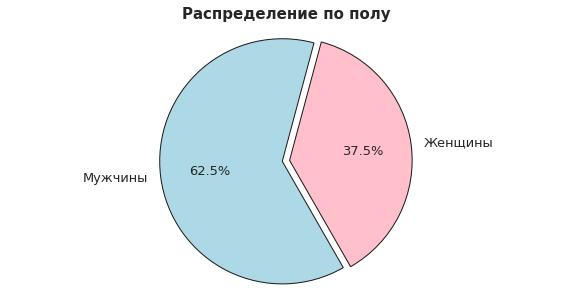

In [7]:
plt.figure(figsize=(10, 5))
textprops = {'fontsize':13}
pie_gender_table = client_info.groupby('gender').count()['cl_brw']
pielabels = ['Мужчины', 'Женщины']
explode = (0.03, 0.03)
plt.pie(x=pie_gender_table, explode=explode,
        labels=pielabels, startangle=75, colors=['lightblue', 'pink'], 
        autopct='%1.1f%%',
        textprops=textprops, wedgeprops={'edgecolor':'k','linewidth': 1, 'antialiased': True})
plt.title('Распределение по полу', fontsize=15, fontweight=800)
plt.axis('equal')
plt.show()

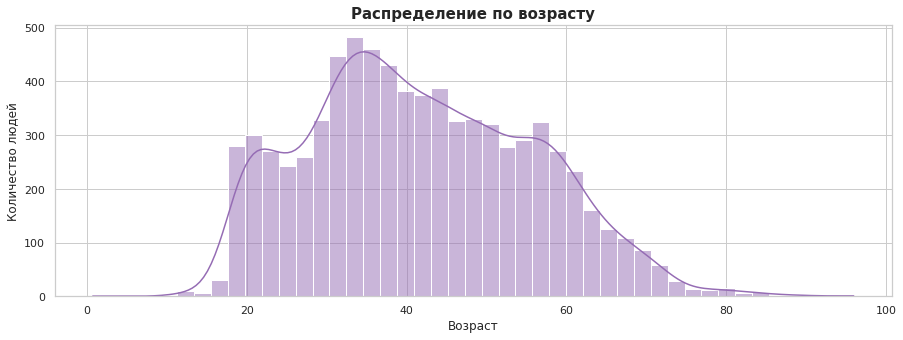

In [8]:
plt.figure(figsize=(15, 5))
age_table = client_info['age']
sns.histplot(x=age_table, kde=True, color='m')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение по возрасту', fontsize=15, fontweight='heavy')
plt.show()

На графике ниже изображено, как сильно люди различных возрастов и полов склонны к кредиту.

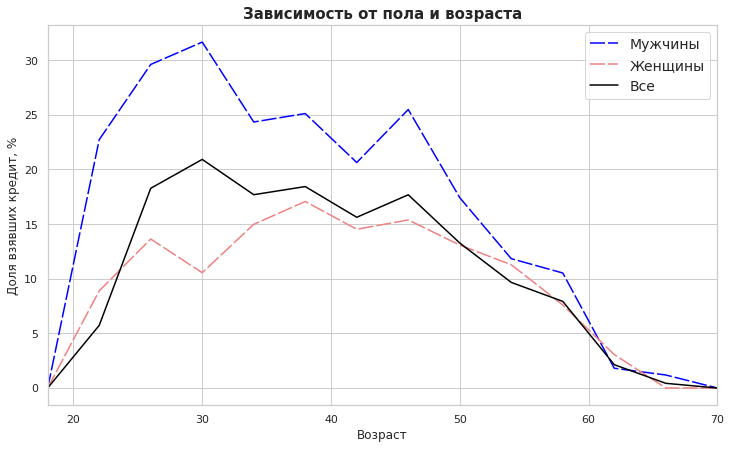

In [9]:
fig = plt.figure(figsize=(12, 7))
gap = 4

age_group = client_info['age'] // gap * gap + gap / 2

grouped_male = client_info.loc[client_info.gender == 0, 
                               'cl_brw'].groupby(age_group)

male_data = grouped_male.mean() * 100

grouped_female = client_info.loc[client_info.gender == 1, 
                                 'cl_brw'].groupby(age_group)
                                 
female_data = grouped_female.mean() * 100

grouped = client_info['cl_brw'].groupby(age_group)
age_data = grouped.mean() * 100

all_together = pd.DataFrame(data={'Мужчины': male_data, 
                                  'Женщины': female_data,
                                  'Все': age_data})

sns.lineplot(data=all_together, 
             palette=['blue', 'lightcoral', 'black'],
             dashes=[(10, 2), (10, 2), '']
             )

plt.title('Зависимость от пола и возраста', fontsize=15, fontweight='heavy')
plt.xlabel('Возраст')
plt.ylabel('Доля взявших кредит, %')
plt.xlim((18, 70))
plt.legend(fontsize=14, loc=1)
plt.show()

Можно сделать вывод, что среди всех мужчин, наиболее склонных к взятию кредита, являются те, чей возраст от 22 до 40 лет. Женщины в свою очерень сохраняют свою относительно высокую склонность к кредиту в возрасте до 52 лет. Также можно заметить, что мужчины более склонны к кредиту, чем женщины.

#### <font color='brown'>*Доход*</font>

Изучим, как распределены данные по средней зарплате за недавнее время.

In [10]:
salary_nans = client_info['salary'].isna().sum() / len(client_info['salary']) * 100
print('У {:.0f}% клиентов есть данные об их зарплате.'.format(100 - salary_nans))

У 54% клиентов есть данные об их зарплате.


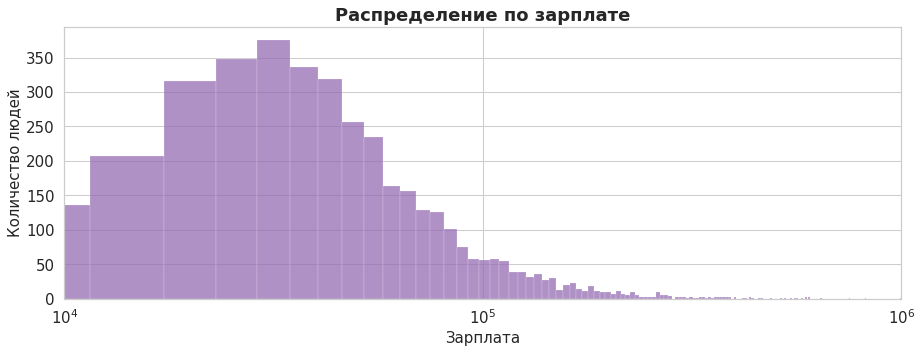

In [11]:
plt.figure(figsize=(15, 5))
salary_table = client_info['salary']
sns.histplot(x=salary_table,  color='m')
plt.xlabel('Зарплата', fontsize=15)
plt.ylabel('Количество людей', fontsize=15)
plt.title('Распределение по зарплате', fontsize=18, fontweight='heavy')
plt.xscale('log')
plt.xlim(10000, 1e6)
plt.tick_params(labelsize=15)
plt.show()

Финансовое положение и кредитный опыт должны сильно влиять на склонность к кредиту. Проверим это.

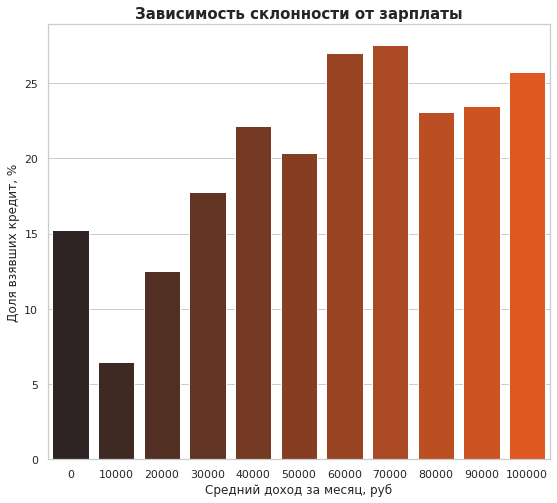

In [12]:
plt.figure(figsize=(9, 8))
salary = 'salary'

gap = 10000
salary_info = client_info[[salary, 'cl_brw']].groupby(np.ceil(client_info[salary] / gap)).mean()

salary_info = salary_info.loc[:10]
with sns.dark_palette("xkcd:blood orange", n_colors=11):
  sns.barplot(x=salary_info.index.astype('int64') * gap, y=salary_info.cl_brw * 100)

plt.xlabel('Средний доход за месяц, руб')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от зарплаты', fontsize=15, fontweight='heavy')
plt.show()

Получается, что при увеличении дохода склонность к кредиту увеличивается.

#### <font color='brown'>*Кредитная история*</font>

**Закрытые кредиты**

In [13]:
cnt_closed_nans = client_info['cnt_closed'].isna().sum() / len(client_info['cnt_closed']) * 100
print('У {:.0f}% клиентов есть данные об их закрытых кредитах.'.format(100 - cnt_closed_nans))

У 67% клиентов есть данные об их закрытых кредитах.


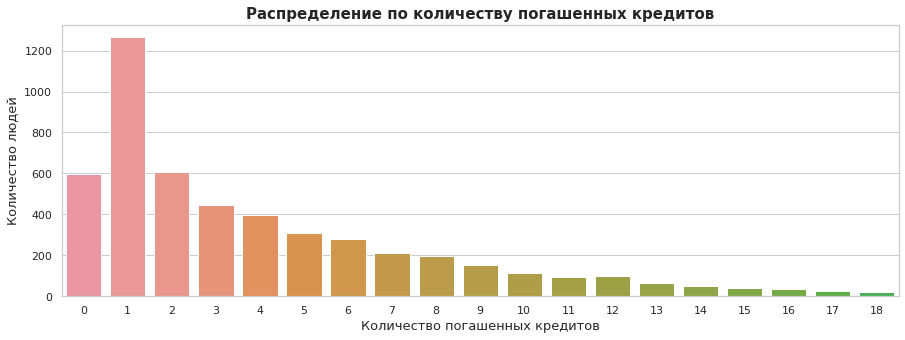

In [14]:
sns.set(context='notebook', style='whitegrid', palette='RdBu')
plt.figure(figsize=(15, 5))
cnt_closed_table = np.ceil(client_info['cnt_closed'].dropna()).astype('int64')
sns.countplot(x=cnt_closed_table)
plt.xlabel('Количество погашенных кредитов', fontsize=13)
plt.ylabel('Количество людей', fontsize=13)
plt.xlim(-0.5, 18.5)
plt.title('Распределение по количеству погашенных кредитов',
          fontsize=15, fontweight='heavy')
plt.show()

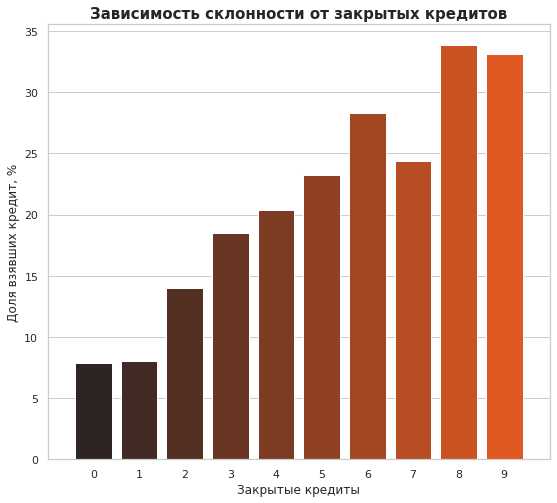

In [15]:
plt.figure(figsize=(9, 8))
closed_att = 'cnt_closed'
closed_info = client_info[[closed_att, 'cl_brw']].groupby(np.ceil(client_info[closed_att])).mean()

closed_info = closed_info[closed_info.index < 10]
with sns.dark_palette("xkcd:blood orange", n_colors=10):
  sns.barplot(x=closed_info.index.astype('int64'), y=closed_info.cl_brw * 100)
plt.xlim(-1, 10)
plt.xlabel('Закрытые кредиты')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от закрытых кредитов', fontsize=15, fontweight='heavy')
plt.show()

Изучив график, можно сделать вывод, что чем больше человек имеет закрытых кредитов, тем с большей вероятностью он возьмет новый.

**Открытые кредиты**

In [16]:
cnt_opened_nans = client_info['cnt_opened'].isna().sum() / len(client_info['cnt_opened']) * 100
print('У {:.0f}% клиентов есть данные об их открытых кредитах.'.format(100 - cnt_opened_nans))

У 67% клиентов есть данные об их открытых кредитах.


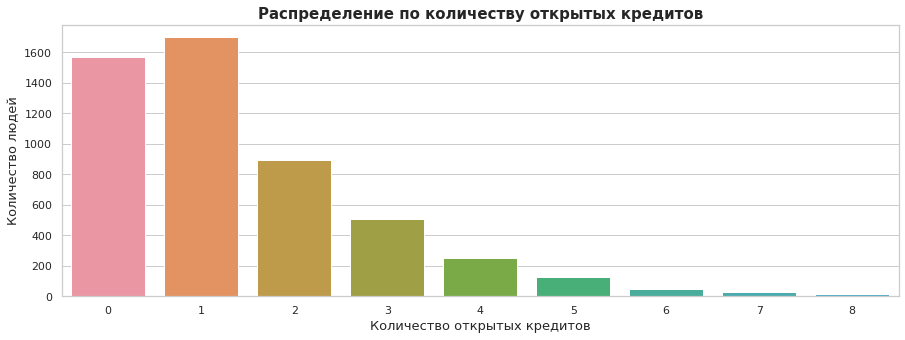

In [17]:
sns.set(context='notebook', style='whitegrid', palette='RdBu')
plt.figure(figsize=(15, 5))
cnt_opened_table = np.ceil(client_info['cnt_opened'].dropna()).astype('int64')
sns.countplot(x=cnt_opened_table)
plt.xlabel('Количество открытых кредитов', fontsize=13)
plt.ylabel('Количество людей', fontsize=13)
plt.xlim(-0.5, 8.5)
plt.title('Распределение по количеству открытых кредитов',
          fontsize=15, fontweight='heavy')
plt.show()

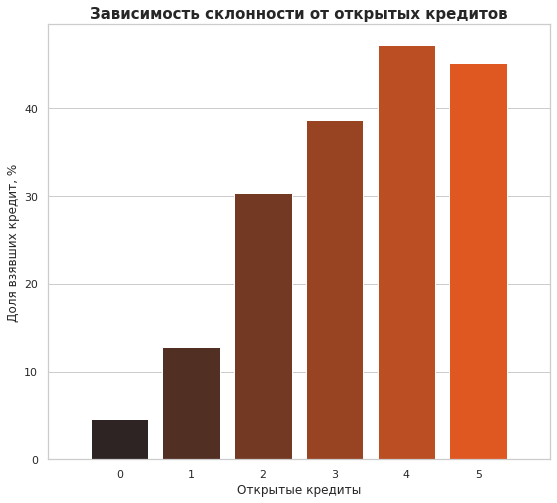

In [18]:
plt.figure(figsize=(9, 8))
opened_att = 'cnt_opened'
opened_info = client_info[[opened_att, 'cl_brw']].groupby(np.ceil(client_info[opened_att])).mean().loc[:5]

with sns.dark_palette("xkcd:blood orange", n_colors=6):
  sns.barplot(x=opened_info.index.astype('int64'), y=opened_info.cl_brw * 100)
plt.xlim(-1, 6)
plt.xlabel('Открытые кредиты')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от открытых кредитов', fontsize=15, fontweight='heavy')
plt.show()

Таким образом, чем больше открытых потребительских кредитов имеет человек, тем выше его склонность к открытию нового.

**Кредитные карты**

In [19]:
credit_nans = client_info['num_credit_cards'].isna().sum() / len(client_info['num_credit_cards'])  * 100
print('У {:.0f}% клиентов есть данные об их кредитных картах.'.format(100 - credit_nans))

У 100% клиентов есть данные об их кредитных картах.


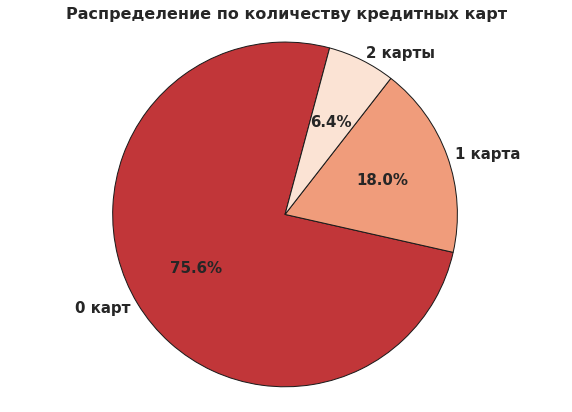

In [20]:
pie_credit_card_table = client_info.groupby(np.ceil(client_info.num_credit_cards)).count()['cl_brw'].loc[:2]
sns.set(context='notebook', style='whitegrid', palette='RdBu')
plt.figure(figsize=(10, 7))
textprops = {'fontsize':15, 'fontweight':'heavy'}
pielabels = ['0 карт', '1 карта', '2 карты']
plt.pie(x=pie_credit_card_table, 
        labels=pielabels, 
        startangle=75, 
        autopct='%1.1f%%', 
        labeldistance=1.05,
        textprops=textprops, 
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})

plt.title('Распределение по количеству кредитных карт',
          fontsize=16, fontweight=1000)
plt.axis('equal')
plt.show()

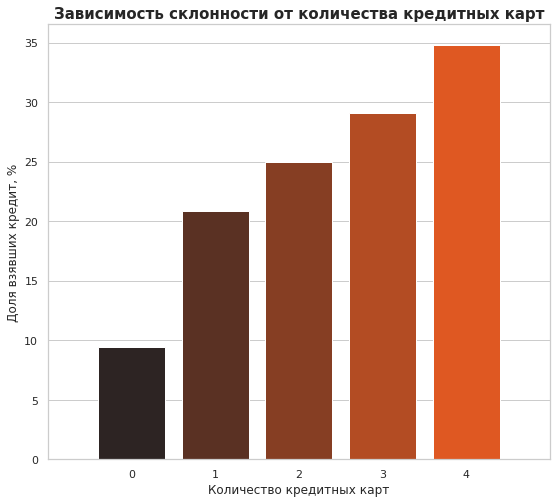

In [21]:
plt.figure(figsize=(9, 8))
att = 'num_credit_cards'
dep_info = client_info[[att, 'cl_brw']].groupby(np.ceil(client_info[att])).mean().loc[:4]

with sns.dark_palette("xkcd:blood orange", n_colors=5):
  sns.barplot(x=dep_info.index.astype('int64'), y=dep_info.cl_brw * 100)
plt.xlim(-1, 5)
plt.xlabel('Количество кредитных карт')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от количества кредитных карт', fontsize=15, fontweight='heavy')
plt.show()

Изучив график, можно сделать вывод, чем больше у клиента кредитных карт, тем выше его склонность к взятию кредита.

**Задолженности**

In [22]:
outstanding_nans = client_info['outstanding_ratio'].isna().sum() / len(client_info['outstanding_ratio']) * 100
print('У {:.0f}% клиентов есть данные об их задолженностях.'.format(100 - outstanding_nans))

У 45% клиентов есть данные об их задолженностях.


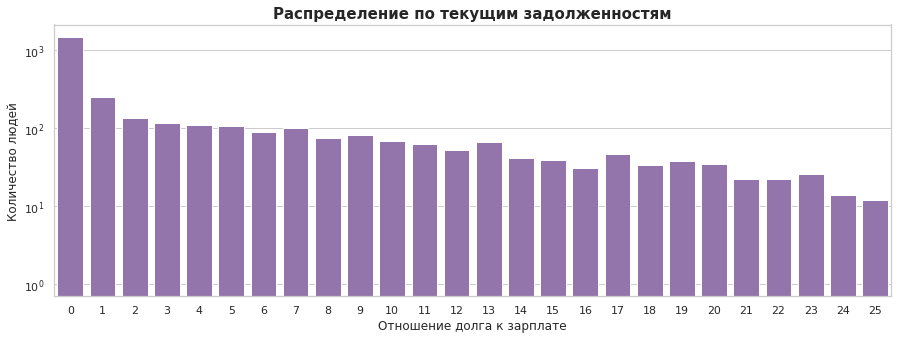

In [23]:
plt.figure(figsize=(15, 5))
debt_table = np.ceil(client_info['outstanding_ratio'].dropna()).astype('int64')
sns.countplot(x=debt_table, color='m')
plt.yscale('log')
plt.xlabel('Отношение долга к зарплате')
plt.ylabel('Количество людей')
plt.title('Распределение по текущим задолженностям', fontsize=15, fontweight='heavy')
plt.xlim(-0.5, 25.5)
plt.xticks(np.arange(26))
plt.show()

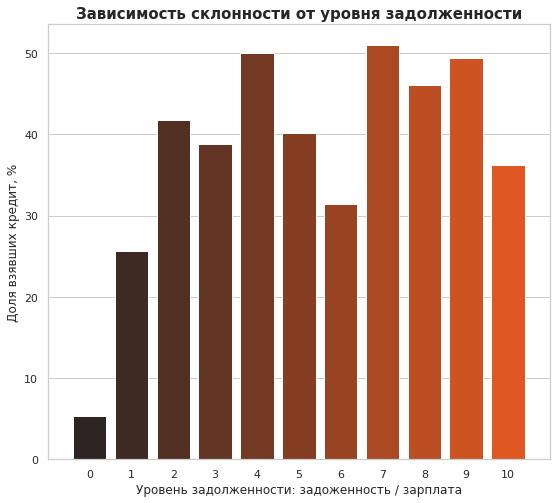

In [24]:
plt.figure(figsize=(9, 8))
att = 'outstanding_ratio'
debt_info = client_info[[att, 'cl_brw']].groupby(np.ceil(client_info[att])).mean().loc[:10]

with sns.dark_palette("xkcd:blood orange", n_colors=11):
  sns.barplot(x=debt_info.index.astype('int64'), y=debt_info.cl_brw * 100)
plt.xlim(-1, 11)
plt.xlabel('Уровень задолженности: задоженнoсть / зарплата')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от уровня задолженности', fontsize=15, fontweight='heavy')
plt.show()

Таким образом, клиенты, чей уровень задолжности (отношение задолжности к зароботной плате) превышает 2, имеют большую склонность к взятию нового кредита. Клиенты без задолжностей или чья задолжность сопоставима с их доходами скорее всего не возьмут новый кредит.

#### <font color='brown'>*Счета*</font>

**Дебетовые карты**

In [25]:
debit_nans = client_info['num_debit_cards'].isna().sum() / len(client_info['num_debit_cards'])  * 100
print('У {:.0f}% клиентов есть данные об их дебетовых картах.'.format(100 - debit_nans))

У 100% клиентов есть данные об их дебетовых картах.


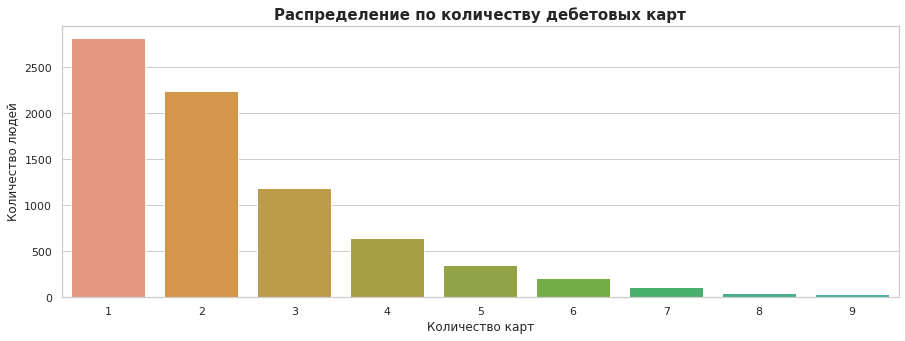

In [26]:
sns.set(context='notebook', style='whitegrid', palette='RdBu')
plt.figure(figsize=(15, 5))
cards_table = np.ceil(client_info['num_debit_cards'].dropna()).astype('int64')
sns.countplot(x=cards_table)
plt.xlabel('Количество карт')
plt.ylabel('Количество людей')
plt.xlim(0.5, 9.5)
plt.title('Распределение по количеству дебетовых карт',
          fontsize=15, fontweight='heavy')
plt.show()

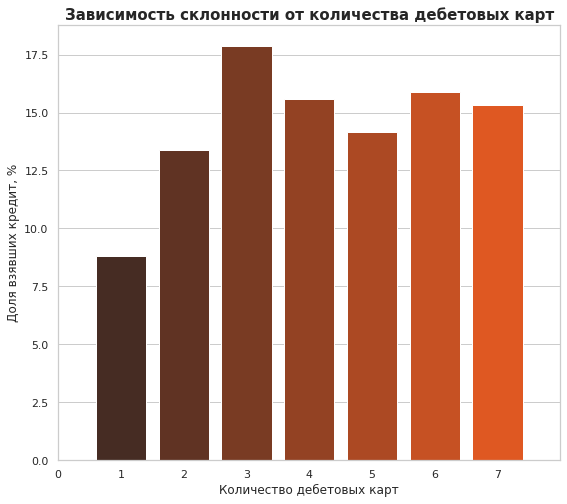

In [27]:
plt.figure(figsize=(9, 8))
att = 'num_debit_cards'
dep_info = client_info[[att, 'cl_brw']].groupby(np.ceil(client_info[att])).mean().loc[:7]

with sns.dark_palette("xkcd:blood orange", n_colors=8):
  sns.barplot(x=dep_info.index.astype('int64'), y=dep_info.cl_brw * 100)
plt.xlim(0, 8)
plt.xlabel('Количество дебетовых карт')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от количества дебетовых карт', fontsize=15, fontweight='heavy')
plt.show()

Чем больше дебетовых карт у клиента, тем выше его склонность к взятию кредита.

**Депозиты**

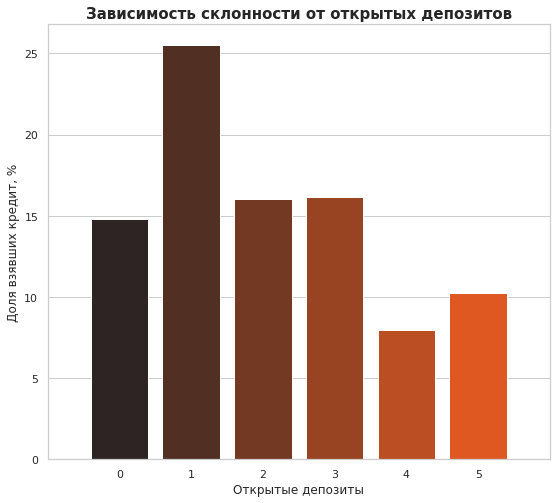

In [28]:
plt.figure(figsize=(9, 8))
att = 'cnt_dep_5y'
dep_info = client_info[[att, 'cl_brw']].groupby(np.ceil(client_info[att])).mean().loc[:5]

with sns.dark_palette("xkcd:blood orange", n_colors=6):
  sns.barplot(x=dep_info.index.astype('int64'), y=dep_info.cl_brw * 100)
plt.xlim(-1, 6)
plt.xlabel('Открытые депозиты')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от открытых депозитов', fontsize=15, fontweight='heavy')
plt.show()

Заметим, с увеличением количества открытых депозитов, склонность клиента к взятию кредита уменьшается.

#### <font color='brown'>*Образование*</font>

In [29]:
edu_nans = client_info['edu_num'].isna().sum() / len(client_info['edu_num']) * 100
print('У {:.0f}% клиентов есть данные об их образовании.'.format(100 - edu_nans))

У 29% клиентов есть данные об их образовании.


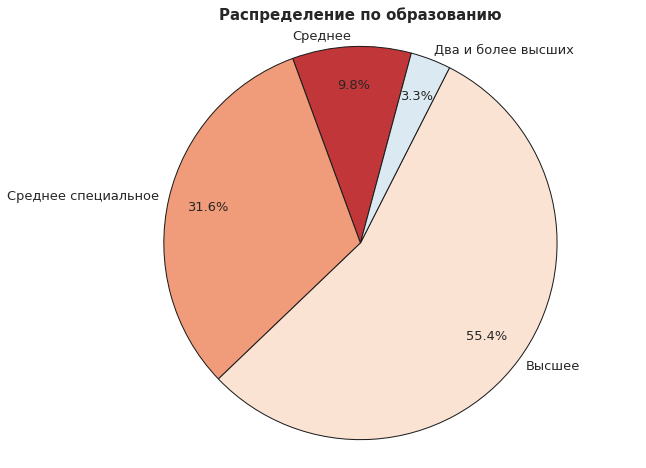

In [30]:
sns.set(context='notebook', style='whitegrid', palette='RdBu')
plt.figure(figsize=(10, 8))
textprops = {'fontsize':13}
pie_edu_table = client_info.groupby('edu_num').count()['cl_brw']
pielabels = ['Среднее', 'Среднее специальное', 
                            'Высшее','Два и более высших']
plt.pie(x=pie_edu_table, labels=pielabels, startangle=75, autopct='%1.1f%%', 
         pctdistance= 0.8, labeldistance=1.05,
        textprops=textprops, wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})
plt.title('Распределение по образованию', fontsize=15, fontweight='heavy')
plt.axis('equal')
plt.show()

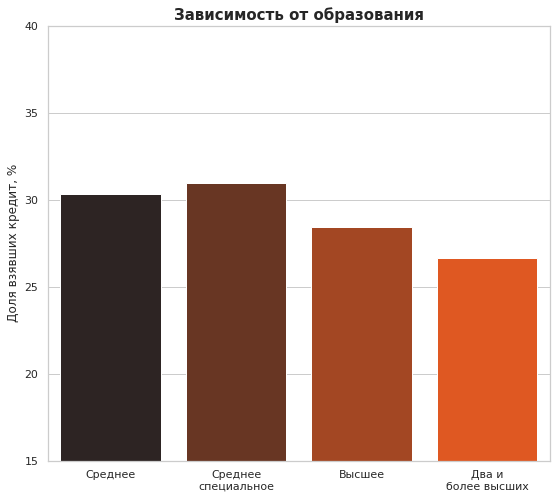

In [31]:
plt.figure(figsize=(9, 8))
edu_info = client_info[['edu_num', 'cl_brw']].groupby(np.ceil(client_info['edu_num'])).mean()

with sns.dark_palette("xkcd:blood orange", n_colors=4):
  sns.barplot(x=edu_info.edu_num.astype('int64'), y=edu_info.cl_brw * 100)
labels = ['Среднее', 'Среднее\nспециальное', 
                            'Высшее','Два и\nболее высших']
plt.xticks(np.arange(4), labels)
plt.ylim(15, 40)
plt.xlabel('')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость от образования', fontsize=15, fontweight='heavy')
plt.show()

Можно сделать вывод, что чем более высокое образование получил человек, тем менее он склонен к кредиту.

#### <font color='brown'>*Наличие автомобиля*</font>

In [32]:
car_nans = client_info['app_vehicle_ind'].isna().sum() / len(client_info['app_vehicle_ind']) * 100
print('У {:.0f}% клиентов есть данные о наличии у них автомобиля.'.format(100 - car_nans))

У 37% клиентов есть данные о наличии у них автомобиля.


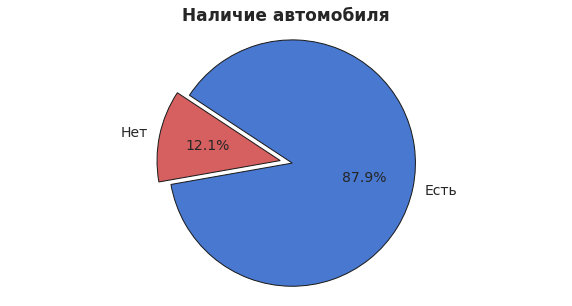

In [33]:
plt.figure(figsize=(10, 5))
textprops = {'fontsize':14}
pie_car_table = client_info.groupby(np.ceil(client_info.app_vehicle_ind)).count()['cl_brw']
carlabels = ['Есть', 'Нет']
explode = (0.05, 0.05)
plt.pie(x=pie_car_table,
        explode=explode,
        labels=carlabels, 
        colors=['b', 'r'], 
        startangle=190, 
        autopct='%1.1f%%',
        textprops=textprops,
        wedgeprops={'edgecolor':'k','linewidth': 1, 'antialiased': True})
plt.title('Наличие автомобиля', fontsize=17, fontweight=800)
plt.axis('equal')
plt.show()

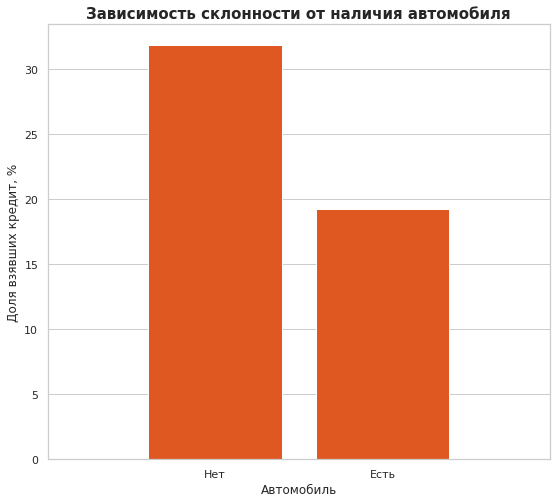

In [34]:
plt.figure(figsize=(9, 8))
att = 'app_vehicle_ind'
dep_info = client_info[[att, 'cl_brw']].groupby(np.ceil(client_info[att])).mean().loc[:1]


sns.barplot(x=dep_info.index.astype('int64'), y=dep_info.cl_brw * 100, 
            color='xkcd:blood orange')
plt.xlim(-1, 2)
plt.xlabel('Автомобиль')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от наличия автомобиля', fontsize=15, fontweight='heavy')
plt.xticks(np.arange(2), ['Нет', 'Есть'])
plt.show()

Получается, что люди без автомобиля более склонны к кредиту

#### <font color='brown'>*Картина потребления*</font>

Проанализируем, как изменяется склонность к кредиту в зависимости от размера трат на разные категории товаров и услуг.

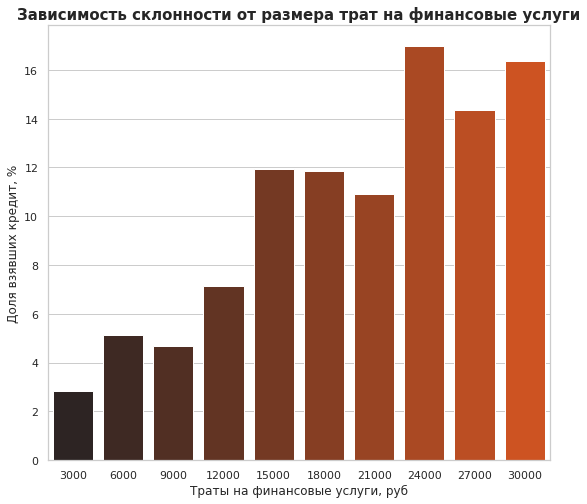

In [35]:
plt.figure(figsize=(9, 8))
attr = 'fin_spends'

gap = 3000
data = client_info[[attr, 'cl_brw']].groupby(np.ceil(client_info[attr] / gap)).mean()

data = data.loc[:10]
with sns.dark_palette("xkcd:blood orange", n_colors=11):
  sns.barplot(x=data.index.astype('int64') * gap, y=data.cl_brw * 100)

plt.xlabel('Траты на финансовые услуги, руб')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от размера трат на финансовые услуги', fontsize=15, fontweight='heavy')
plt.show()

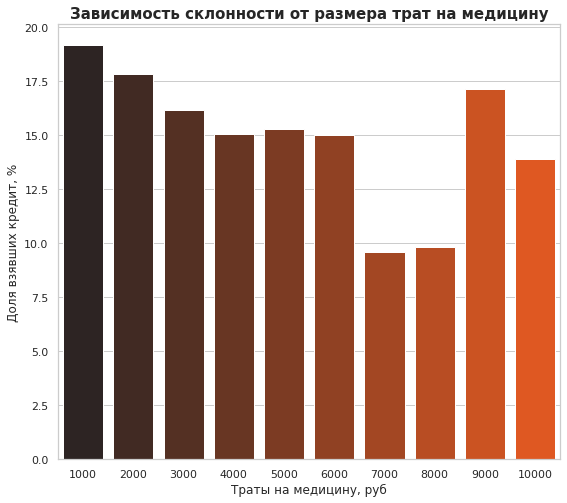

In [36]:
plt.figure(figsize=(9, 8))
attr = 'med_spends'

gap = 1000
data = client_info[[attr, 'cl_brw']].groupby(np.ceil(client_info[attr] / gap)).mean()

data = data.loc[:10]
with sns.dark_palette("xkcd:blood orange", n_colors=10):
  sns.barplot(x=data.index.astype('int64') * gap, y=data.cl_brw * 100)

plt.xlabel('Траты на медицину, руб')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от размера трат на медицину', fontsize=15, fontweight='heavy')
plt.show()

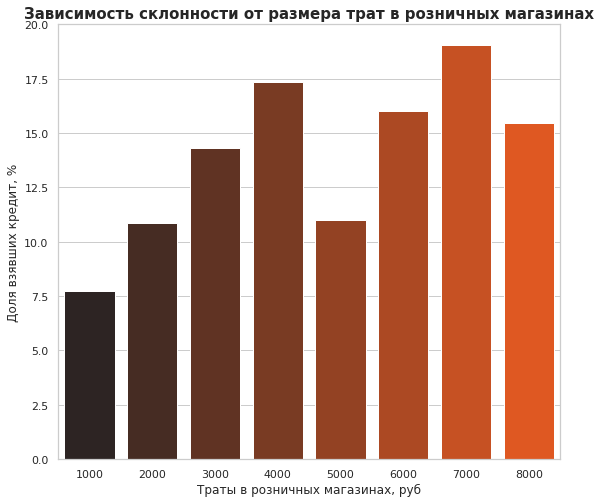

In [37]:
plt.figure(figsize=(9, 8))
attr = 'stor_spends'

gap = 1000
data = client_info[[attr, 'cl_brw']].groupby(np.ceil(client_info[attr] / gap)).mean()

data = data.loc[:8]
with sns.dark_palette("xkcd:blood orange", n_colors=8):
  sns.barplot(x=data.index.astype('int64') * gap, y=data.cl_brw * 100)

plt.xlabel('Траты в розничных магазинах, руб')
plt.ylabel('Доля взявших кредит, %')
plt.title('Зависимость склонности от размера трат в розничных магазинах', fontsize=15, fontweight='heavy')
plt.show()

Можно сделать вывод, что между склонностью к кредиту и суммой трат на некоторые категории товаров существует прямая или обратная зависимость.

### **4. Модель**

#### <font color='brown'>*Подготовка данных*</font>

Заполним пропуски в данных

In [38]:
data = client_info.copy()

for attr in attributes:
  data[attr].fillna(value=data[attr].mean(), inplace=True)
  
for attr in mode_attributes:
  data[attr].fillna(value=data[attr].mode()[0], inplace=True)

#### <font color='brown'>*Метрика*</font>

С одной стороны, мы не должны упускать потенциальных клиентов. С другой стороны, не нужно часто показывать рекламу незаинтересованным клиентам.

Метрика оценивает, насколько хорошо модель справляется с этими задачами.

In [39]:
def metric(y_true, y_pred):
    return (y_true * (1 - y_pred) * 0.8 + (1 - y_true) * y_pred * 0.6).mean()

#### <font color='brown'>*Обучение модели*</font>

In [40]:
cl_true = data[data.cl_brw]
cl_false = data[~data.cl_brw]
cnt = min(cl_true.count()[0], cl_false.count()[0])
sampled_data = cl_true.sample(cnt).append(cl_false.sample(cnt))

x = sampled_data.drop(columns=['cl_brw'])
y = sampled_data['cl_brw'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [41]:
regressor = RandomForestRegressor(n_estimators=10, 
                                  criterion='friedman_mse')
regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='friedman_mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### <font color='brown'>*Анализ результатов*</font>

Оценим значение метрики для нашей модели

In [42]:
def sigmoid(lap, scale):
  return lambda x : 1 / (1 + np.e ** (-scale*(x - lap)))

def predict(x):
  return sigmoid(.3, 30)(regressor.predict(x_test))

def accuracy(y_true, y_pred):
  return (1 - (y_true - y_pred) ** 2).mean()

y_pred = predict(x_test)
res = metric(y_test, y_pred)
acc = accuracy(y_test, (y_pred > 0.5))

print("Значение метрики: {:.2f}".format(res))
print("Точность предсказания: {:.1f}%".format(acc * 100))

Значение метрики: 0.13
Точность предсказания: 79.7%


Оценим значение метрики для примитивных моделей

*   Предсказываем всегда минимальную склонность
*   Предсказываем всегда максимальную склонность
*   Предсказываем склонность случайным образом

In [43]:
res0 = metric(y_test, np.zeros(y_pred.shape))
res1 = metric(y_test, np.ones(y_pred.shape))
resR = metric(y_test, np.random.random(y_pred.shape))

print("Значение метрики примитивных моделей: {:.2f} {:.2f} {:.2f}".format(res0, res1, resR))

Значение метрики примитивных моделей: 0.38 0.31 0.34


Наша модель предсказывает склонность к кредиту намного более точно, чем примитивные модели. 

Таким образом, бизнес может применить данную модель для предсказания склонности клиентов к кредиту. 